In [1]:
# Importation des bibliothèques nécessaires
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

from sklearn.cluster import SpectralClustering 

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw= stopwords.words('english')

from transformers import DistilBertTokenizer,DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification,DistilBertModel
from sentence_transformers import SentenceTransformer
model_ = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# SentenceTransformers est un framework Python pour les incorporations de phrases, de textes et d'images

2023-05-23 10:20:30.319197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 10:20:30.575399: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 10:20:30.621575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-23 10:20:30.621623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
# Import des données
train= pd.read_csv('emotion_train.txt',delimiter=';',header=None,names=['sentence','label'])
df_test= pd.read_csv ('emotion_test.txt',delimiter=';',header=None,names=['sentence','label'])
valid= pd.read_csv('emotion_val.txt',delimiter=';',header=None, names=['sentence','label'])

In [1]:
import os
ADULT_PATH = os.path.join(os.getcwd(), 'emotion_train.txt')

In [5]:
data = pd.read_csv(ADULT_PATH)

In [4]:
import pandas as pd

In [2]:
ADULT_PATH

'/home/titontshiongo/Documents/Projet_Biais_inconnus/emotion_train.txt'

In [4]:
df_train=pd.concat([train,valid])

In [5]:
df_train['encoded_labels'] = df_train['label'].astype('category').cat.codes
df_test['encoded_labels'] = df_test['label'].astype('category').cat.codes

# Représentation vectorielle des données d'entraînement et de test avec Distilbert

In [6]:
# Pour les données d'entraînement
X_train = df_train['sentence']
Corpus_train=X_train.tolist()
X_train_vec = model_.encode(Corpus_train)

In [7]:
X_train_vec

array([[-1.1544638 ,  0.10312171, -0.38413462, ...,  0.2881617 ,
         0.12993605, -0.20148802],
       [-0.5989041 ,  0.29231188,  0.23062254, ..., -0.26587018,
         0.15133835, -0.3285197 ],
       [-0.00760707,  0.40448916,  0.40215147, ..., -0.6672771 ,
        -0.51372916,  1.107869  ],
       ...,
       [ 0.52225536,  0.22991903,  0.7359465 , ...,  0.6286719 ,
        -0.8312252 , -0.2977521 ],
       [ 0.20296595,  0.12611374,  0.2692463 , ..., -0.5032531 ,
         0.1165732 , -1.0425922 ],
       [-0.04230396,  0.29624194,  0.59780896, ..., -0.23336725,
        -0.5972549 , -0.0692785 ]], dtype=float32)

In [8]:
# Pour les données test
X_test = df_test['sentence']
Corpus_test=X_test.tolist()
X_test_vec = model_.encode(Corpus_test)

In [9]:
# Dimension de la représentation Distilbert-->768
X_train_vec.shape,X_test_vec.shape

((18000, 768), (2000, 768))

# Réduction de dimension avec auto encodeur

In [10]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

input_dim = 768 # Dimension du modèle pré-entraîné Ditilbert => 768
latent_vec_dim = 128 # Dimension souhaitée pour notre espace latent

input_layer = Input(shape=(input_dim,))

# Construction de l'encoder

enc_layer_1 = Dense(512, activation='relu')(input_layer)
enc_layer_2 = Dense(256, activation='relu')(enc_layer_1)
#enc_layer_3 = Dense(128, activation='relu')(enc_layer_2)
latent_layer_3 = Dense(latent_vec_dim, activation='relu',name="espace_latent")(enc_layer_2)
encoder = latent_layer_3

# Construction du decoder

dec_layer_1 = Dense(256, activation='relu')(encoder)
dec_layer_2 = Dense(512, activation='relu')(dec_layer_1)
dec_layer_3 = Dense(512, activation='relu')(dec_layer_2)
dec_layer_3 = Dense(input_dim, activation='relu')(dec_layer_2)
decoder = dec_layer_3

# Connection de l'encodeur et décodeur 
autoencoder = Model(input_layer, decoder, name="Autoencoder")
# Latent representation (Optional)
latent_model = Model(input_layer, encoder)


autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 512)               393728    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 espace_latent (Dense)       (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 768)               

2023-05-23 10:28:05.961423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-23 10:28:05.961637: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-23 10:28:05.961660: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valnan): /proc/driver/nvidia/version does not exist
2023-05-23 10:28:05.962180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# reduction de dimension sur les données train et test
encoder = Model(input_layer, latent_layer_3 )

X_train_reduced = encoder.predict(X_train_vec)
X_test_reduced = encoder.predict(X_test_vec)

63/63 [==============================] - 0s 2ms/step


In [12]:
# vérification de la dimension après réduction
X_train_reduced.shape,X_test_reduced.shape

((18000, 128), (2000, 128))

# Clusterisation des données réduites en dimension 128

In [13]:
# Clusterisation avec SpectralClustering
sc = SpectralClustering(n_clusters=10, random_state=42, affinity='nearest_neighbors')
sc.fit(X_train_vec)


SpectralClustering(affinity='nearest_neighbors', n_clusters=10, random_state=42)

In [14]:
train_labels = sc.labels_

y_pred = sc.fit_predict(X_test_vec)

/home/titontshiongo/anaconda3/lib/python3.10/site-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


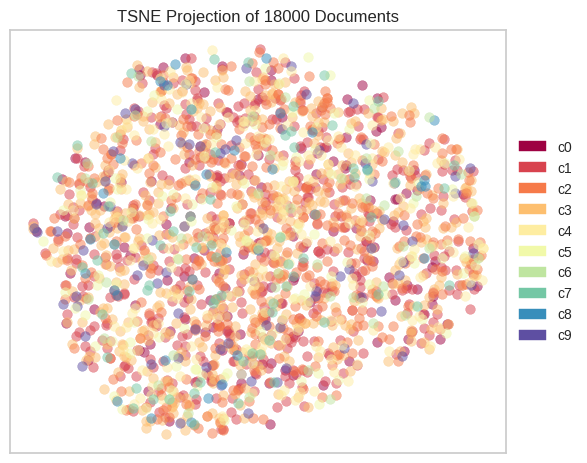

<Axes: title={'center': 'TSNE Projection of 18000 Documents'}>

In [15]:
# Visualisation des clusters en dimension 128
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer(decompose_by=10,colormap='Spectral',random_state=0, alpha=0.5)
tsne.fit(X_train_reduced, ["c{}".format(c) for c in sc.labels_])
tsne.show()

# Detection des erreurs dans les clusters

In [22]:
y_true= df_test.encoded_labels

In [23]:
# Calcul du pourcentage d'erreurs dans chaque cluster
cluster_counts = np.unique(y_pred, return_counts=True)[1]
errors = []
for cluster in range(10):
    mask = (y_pred == cluster)
    cluster_labels = y_true[mask]
    error = 1 - np.sum(cluster_labels == np.argmax(np.bincount(cluster_labels))) / len(cluster_labels)
    error_percentage = error * np.sum(mask) / len(y_pred)
    errors.append(error_percentage)
    print(f"Cluster {cluster+1}: {error_percentage:.2%} erreur")

Cluster 1: 5.20% erreur
Cluster 2: 8.20% erreur
Cluster 3: 1.25% erreur
Cluster 4: 4.45% erreur
Cluster 5: 6.45% erreur
Cluster 6: 5.60% erreur
Cluster 7: 1.65% erreur
Cluster 8: 2.05% erreur
Cluster 9: 3.30% erreur
Cluster 10: 10.20% erreur


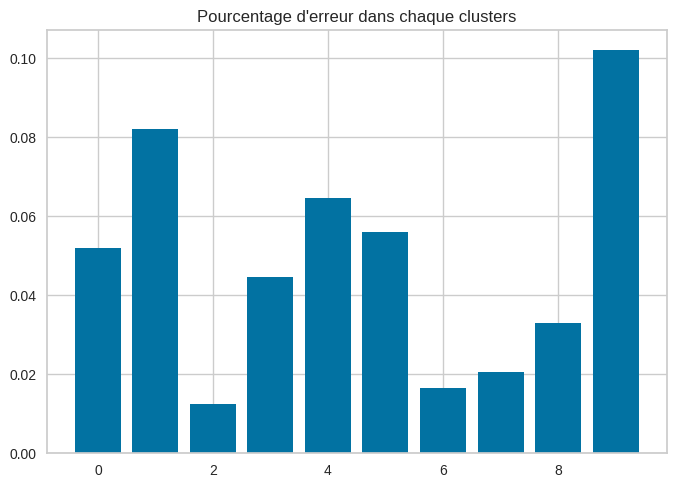

In [24]:
# Affichage des pourcentages d'erreurs
plt.bar(range(10), errors)
plt.title("Pourcentage d'erreur dans chaque clusters")
plt.show()

In [31]:

y_pred = sc.fit_predict(X_train_vec)

In [32]:
df_train["nom_cluster"] = y_pred 

In [33]:
df_train.head()

,sentence,label,encoded_labels,nom_cluster
0,i didnt feel humiliated,sadness,4,3
1,i can go from feeling so hopeless to so damned...,sadness,4,0
2,im grabbing a minute to post i feel greedy wrong,anger,0,4
3,i am ever feeling nostalgic about the fireplac...,love,3,0
4,i am feeling grouchy,anger,0,6


# Représentation d'un wordcloud pour les cluster(2,3,4) pour identifier les mots les plus fréquents

In [34]:

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [35]:

df_cluster2=df_train[df_train.nom_cluster == 2]
df_cluster3=df_train[df_train.nom_cluster == 3]
df_cluster4=df_train[df_train.nom_cluster == 4]

In [36]:
df_cluster2.sample(5,random_state=None)

,sentence,label,encoded_labels,nom_cluster
9221,i feel id be passionate to invest my time into...,joy,2,2
940,i make new friends in the process i dont feel ...,love,3,2
12153,im feeling funny a href http,surprise,5,2
7598,i feel so thrilled to share with my fans becau...,joy,2,2
15540,i feel that your prince charming will come thr...,joy,2,2


In [37]:
# Cluster2
text_Cluster2 = " ".join(review for review in df_cluster2.sentence)


In [38]:
wordcloud = WordCloud().generate(text_Cluster2)

In [39]:
print ("There are {} words in the combination of all review.".format(len(text_Cluster2)))

There are 273409 words in the combination of all review.


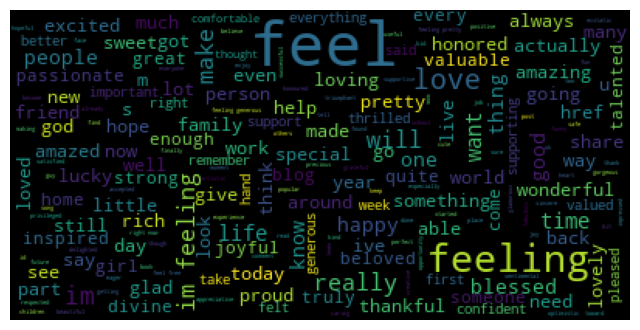

In [40]:
from wordcloud import WordCloud 

wordcloud = WordCloud(max_font_size=40, relative_scaling=.5,max_words=200).generate(text_Cluster2)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [41]:
# Cluster3
text_Cluster3 = " ".join(review for review in df_cluster3.sentence)

In [42]:
wordcloud = WordCloud().generate(text_Cluster3)

In [43]:
print ("There are {} words in the combination of all review.".format(len(text_Cluster3)))

There are 13001 words in the combination of all review.


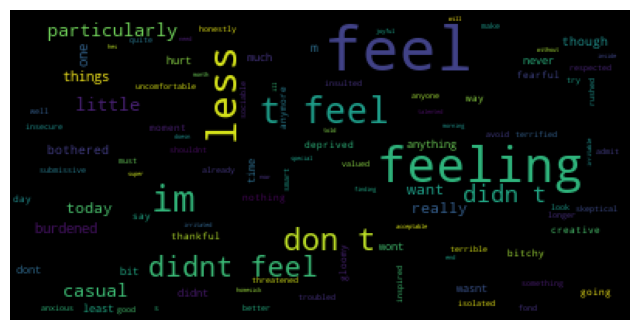

In [44]:
from wordcloud import WordCloud 
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5,max_words=100).generate(text_Cluster3)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [45]:
# Cluster4
text_Cluster4 = " ".join(review for review in df_cluster4.sentence)

In [46]:
wordcloud = WordCloud().generate(text_Cluster4)

In [47]:
print ("There are {} words in the combination of all review.".format(len(text_Cluster4)))

There are 2150 words in the combination of all review.


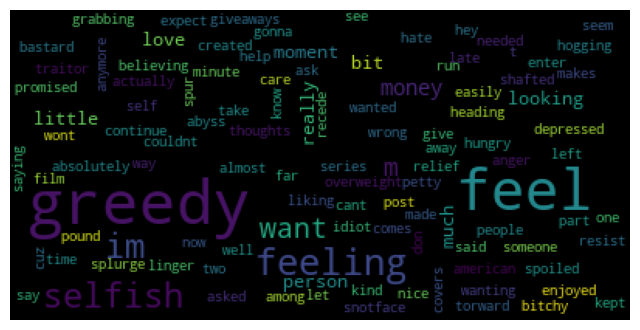

In [48]:
from wordcloud import WordCloud 

wordcloud = WordCloud(max_font_size=40, relative_scaling=.5,max_words=200).generate(text_Cluster4)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [49]:
df_cluster2=df_train[df_train.nom_cluster == 2]

In [51]:
df_cluster2.head()

,sentence,label,encoded_labels,nom_cluster
8,i have been with petronas for years i feel tha...,joy,2,2
9,i feel romantic too,love,3,2
11,i do feel that running is a divine experience ...,joy,2,2
18,i started feeling sentimental about dolls i ha...,sadness,4,2
22,i have the feeling she was amused and delighted,joy,2,2


# Human in the loop

In [52]:
Corpus_cluster2=df_cluster2['sentence'].tolist()

In [53]:
Corpus_cluster2

['i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too',
 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'i started feeling sentimental about dolls i had as a child and so began a collection of vintage barbie dolls from the sixties',
 'i have the feeling she was amused and delighted',
 'i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me',
 'i get giddy over feeling elegant in a perfectly fitted pencil skirt',
 'i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies',
 'i have been feeling the need to be creative',
 'i plan to share my everyday life stories traveling adventures inspirations and handmade creations with you and hope you will also feel inspired',
 'i feel very strongly passionate about when some jerk off 

# Utilisation du modèle pré-entraîné DistilBERT pour calculer la similarité entre les  phrases dans les clusters

In [69]:
df_cluster2.sentence[0:2]
# sentence1='i have been with petronas for years i feel that petronas has performed well and made a huge profit'
# Sentence2='i started feeling sentimental about dolls i had as a child and so began a collection of vintage barbie dolls from the sixties'

8    i have been with petronas for years i feel tha...
9                                  i feel romantic too
Name: sentence, dtype: object

In [ ]:
text_Cluster3
# sentence3='i dont look good i am in no way complaining or whining or feeling ungrateful'
# Sentence4='i feel times less bitchy '
# sentence5='i feel confident that it wasn t my company that was bothering him'

In [78]:
df_cluster4.sentence[0:3]
# sentence6='i do feel that they are greedy and money hungry absolutely'
# sentence7='im grabbing a minute to post i feel greedy wrong'

2       im grabbing a minute to post i feel greedy wrong
52                            i feel selfish and spoiled
502    i do feel that they are greedy and money hungr...
Name: sentence, dtype: object

In [91]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [92]:
model  = SentenceTransformer("bert-base-uncased")

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

No sentence-transformers model found with name /home/titontshiongo/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/titontshiongo/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

In [93]:
print(model)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)


In [95]:
sentences_list = ["i have been with petronas for years i feel that petronas has performed well and made a huge profit",
"i dont look good i am in no way complaining or whining or feeling ungrateful"]

In [96]:
embeddings =  model.encode(sentences_list)

In [97]:
embeddings

array([[ 0.05896804,  0.07247213,  0.01076167, ..., -0.3188834 ,
         0.27287874,  0.08661322],
       [-0.27020046,  0.27438527,  0.22417827, ..., -0.0985889 ,
         0.07584245,  0.06086774]], dtype=float32)

In [102]:
similarite = cosine_similarity(embeddings) 

In [100]:
#calcul du score de similarité entre les phrases du cluster 2 et 3
similarities_pair = cosine_similarity(embeddings[0:1],embeddings[1:2]) 
similarities_pair

array([[0.65553224]], dtype=float32)

In [105]:
#calcul du score de similarité entre les phrases du cluster 2 et 4
sentences_list1 = ["i have been with petronas for years i feel that petronas has performed well and made a huge profit",
"i do feel that they are greedy and money hungry absolutely"]


In [106]:
embeddings1 =  model.encode(sentences_list1)

In [107]:
similarite1 = cosine_similarity(embeddings1) 

In [110]:
similarities_pair1 = cosine_similarity(embeddings1[0:1],embeddings1[1:2])
similarities_pair1 

array([[0.6758349]], dtype=float32)